In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

tf.compat.v1.losses.sparse_softmax_cross_entropy

<function tensorflow.python.ops.losses.losses_impl.sparse_softmax_cross_entropy(labels, logits, weights=1.0, scope=None, loss_collection='losses', reduction='weighted_sum_by_nonzero_weights')>

In [54]:
df = pd.read_excel("energy_generation.xlsx")
df.columns = ["Datetime", "Power_Generation"]

In [55]:
# Display basic information about the dataset
print("=" * 50)
print("First Five Rows ", "\n")
print(df.head(2), "\n")

First Five Rows  

    Datetime  Power_Generation
0 1989-01-01           12039.5
1 1989-02-01            9579.5 



In [56]:
# Display information about the dataset
print("=" * 50)
print("Information About Dataset", "\n")
print(df.info(), "\n")

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime          408 non-null    datetime64[ns]
 1   Power_Generation  408 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.5 KB
None 



In [57]:
# Display summary statistics of the dataset
print("=" * 50)
print("Describe the Dataset ", "\n")
print(df.describe(), "\n")

Describe the Dataset  

                            Datetime  Power_Generation
count                            408        408.000000
mean   2005-12-15 23:03:31.764705920      10973.021348
min              1989-01-01 00:00:00          0.000000
25%              1997-06-23 12:00:00       6277.250000
50%              2005-12-16 12:00:00      10335.000000
75%              2014-06-08 12:00:00      14927.125000
max              2022-12-01 00:00:00      33821.500000
std                              NaN       6504.420610 



In [58]:
# Checking for null values
print("=" * 50)
print("Null Values t ", "\n")
print(df.isnull().sum(), "\n")

Null Values t  

Datetime            0
Power_Generation    0
dtype: int64 



In [59]:
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(1)

,Power_Generation,Month,Year
Datetime,,,
1989-01-01,12039.5,1,1989


In [60]:
n_test_months = 24  # You can adjust this based on your needs
TestData = dataset.tail(n_test_months)
Training_Set = dataset.iloc[:, 0:1]
Training_Set = Training_Set[:-n_test_months]  # Adjust based on the amount of test data

In [61]:
# Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [62]:
def create_sequences(data, lookback=24):
    X, Y = [], []
    for i in range(lookback, data.shape[0]):
        X.append(data[i - lookback:i])
        Y.append(data[i])
    return np.array(X), np.array(Y)

In [63]:
# Creating input sequences for the LSTM model
 # You can adjust this based on your needs
def prepare_test_data(dataset, test_data):
    Df_Total = pd.concat((dataset[["Power_Generation"]], test_data[["Power_Generation"]]), axis=0)
    inputs = Df_Total[len(Df_Total) - len(test_data) - 24:].values
    inputs = inputs.reshape(-1, 1)
    sc = MinMaxScaler(feature_range=(0, 1))
    inputs = sc.fit_transform(inputs)
    return inputs

In [64]:
def reshape_test_data(inputs):
    X_test = []
    for i in range(24, len(inputs)):
        X_test.append(inputs[i - 24:i])
    return np.array(X_test)

In [65]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(input_shape, 1)))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=100,return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    
    model.add(Dense(units=128, activation='relu', input_dim=1))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [66]:
# Creating input sequences for the LSTM model
X_Train, Y_Train = create_sequences(Train)

In [67]:
# Reshaping input sequences for LSTM model
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [68]:
# Building the LSTM model
regressor = build_lstm_model(X_Train.shape[1])

In [69]:
# Compiling and training the LSTM model
regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(X_Train, Y_Train, epochs=500, batch_size=64, validation_split=0.1, verbose=2)
history
tf.compat.v1.ragged.RaggedTensorValue

Epoch 1/500
6/6 - 38s - loss: 0.0751 - val_loss: 0.0533 - 38s/epoch - 6s/step
Epoch 2/500
6/6 - 1s - loss: 0.0365 - val_loss: 0.0466 - 748ms/epoch - 125ms/step
Epoch 3/500
6/6 - 1s - loss: 0.0339 - val_loss: 0.0501 - 688ms/epoch - 115ms/step
Epoch 4/500
6/6 - 1s - loss: 0.0326 - val_loss: 0.0468 - 744ms/epoch - 124ms/step
Epoch 5/500
6/6 - 1s - loss: 0.0330 - val_loss: 0.0545 - 730ms/epoch - 122ms/step
Epoch 6/500
6/6 - 1s - loss: 0.0359 - val_loss: 0.0566 - 821ms/epoch - 137ms/step
Epoch 7/500
6/6 - 1s - loss: 0.0322 - val_loss: 0.0453 - 765ms/epoch - 128ms/step
Epoch 8/500
6/6 - 1s - loss: 0.0316 - val_loss: 0.0483 - 780ms/epoch - 130ms/step
Epoch 9/500
6/6 - 1s - loss: 0.0306 - val_loss: 0.0478 - 1s/epoch - 170ms/step
Epoch 10/500
6/6 - 1s - loss: 0.0310 - val_loss: 0.0563 - 802ms/epoch - 134ms/step
Epoch 11/500
6/6 - 1s - loss: 0.0319 - val_loss: 0.0547 - 738ms/epoch - 123ms/step
Epoch 12/500
6/6 - 1s - loss: 0.0334 - val_loss: 0.0500 - 808ms/epoch - 135ms/step
Epoch 13/500
6/6 - 1

6/6 - 1s - loss: 0.0170 - val_loss: 0.0379 - 819ms/epoch - 136ms/step
Epoch 101/500
6/6 - 1s - loss: 0.0179 - val_loss: 0.0563 - 725ms/epoch - 121ms/step
Epoch 102/500
6/6 - 1s - loss: 0.0189 - val_loss: 0.0480 - 738ms/epoch - 123ms/step
Epoch 103/500
6/6 - 1s - loss: 0.0166 - val_loss: 0.0495 - 710ms/epoch - 118ms/step
Epoch 104/500
6/6 - 1s - loss: 0.0156 - val_loss: 0.0447 - 724ms/epoch - 121ms/step
Epoch 105/500
6/6 - 1s - loss: 0.0144 - val_loss: 0.0503 - 703ms/epoch - 117ms/step
Epoch 106/500
6/6 - 1s - loss: 0.0147 - val_loss: 0.0505 - 719ms/epoch - 120ms/step
Epoch 107/500
6/6 - 1s - loss: 0.0137 - val_loss: 0.0643 - 719ms/epoch - 120ms/step
Epoch 108/500
6/6 - 1s - loss: 0.0137 - val_loss: 0.0453 - 797ms/epoch - 133ms/step
Epoch 109/500
6/6 - 1s - loss: 0.0133 - val_loss: 0.0501 - 749ms/epoch - 125ms/step
Epoch 110/500
6/6 - 1s - loss: 0.0139 - val_loss: 0.0552 - 721ms/epoch - 120ms/step
Epoch 111/500
6/6 - 1s - loss: 0.0130 - val_loss: 0.0454 - 747ms/epoch - 125ms/step
Epoch 

Epoch 198/500
6/6 - 1s - loss: 0.0121 - val_loss: 0.0505 - 659ms/epoch - 110ms/step
Epoch 199/500
6/6 - 1s - loss: 0.0108 - val_loss: 0.0430 - 640ms/epoch - 107ms/step
Epoch 200/500
6/6 - 1s - loss: 0.0149 - val_loss: 0.0382 - 653ms/epoch - 109ms/step
Epoch 201/500
6/6 - 1s - loss: 0.0098 - val_loss: 0.0663 - 716ms/epoch - 119ms/step
Epoch 202/500
6/6 - 1s - loss: 0.0127 - val_loss: 0.0711 - 677ms/epoch - 113ms/step
Epoch 203/500
6/6 - 1s - loss: 0.0094 - val_loss: 0.0416 - 624ms/epoch - 104ms/step
Epoch 204/500
6/6 - 1s - loss: 0.0104 - val_loss: 0.0480 - 651ms/epoch - 108ms/step
Epoch 205/500
6/6 - 1s - loss: 0.0090 - val_loss: 0.0589 - 676ms/epoch - 113ms/step
Epoch 206/500
6/6 - 1s - loss: 0.0092 - val_loss: 0.0768 - 635ms/epoch - 106ms/step
Epoch 207/500
6/6 - 1s - loss: 0.0082 - val_loss: 0.0595 - 753ms/epoch - 126ms/step
Epoch 208/500
6/6 - 1s - loss: 0.0080 - val_loss: 0.0677 - 795ms/epoch - 133ms/step
Epoch 209/500
6/6 - 1s - loss: 0.0083 - val_loss: 0.0545 - 847ms/epoch - 141

Epoch 296/500
6/6 - 1s - loss: 0.0088 - val_loss: 0.0772 - 739ms/epoch - 123ms/step
Epoch 297/500
6/6 - 1s - loss: 0.0076 - val_loss: 0.0727 - 682ms/epoch - 114ms/step
Epoch 298/500
6/6 - 1s - loss: 0.0063 - val_loss: 0.0674 - 699ms/epoch - 117ms/step
Epoch 299/500
6/6 - 1s - loss: 0.0054 - val_loss: 0.0839 - 668ms/epoch - 111ms/step
Epoch 300/500
6/6 - 1s - loss: 0.0059 - val_loss: 0.0616 - 649ms/epoch - 108ms/step
Epoch 301/500
6/6 - 1s - loss: 0.0056 - val_loss: 0.0507 - 666ms/epoch - 111ms/step
Epoch 302/500
6/6 - 1s - loss: 0.0063 - val_loss: 0.0665 - 654ms/epoch - 109ms/step
Epoch 303/500
6/6 - 1s - loss: 0.0062 - val_loss: 0.0526 - 642ms/epoch - 107ms/step
Epoch 304/500
6/6 - 1s - loss: 0.0082 - val_loss: 0.0527 - 653ms/epoch - 109ms/step
Epoch 305/500
6/6 - 1s - loss: 0.0069 - val_loss: 0.0755 - 668ms/epoch - 111ms/step
Epoch 306/500
6/6 - 1s - loss: 0.0086 - val_loss: 0.0716 - 655ms/epoch - 109ms/step
Epoch 307/500
6/6 - 1s - loss: 0.0077 - val_loss: 0.0633 - 676ms/epoch - 113

Epoch 394/500
6/6 - 1s - loss: 0.0021 - val_loss: 0.0651 - 860ms/epoch - 143ms/step
Epoch 395/500
6/6 - 1s - loss: 0.0039 - val_loss: 0.0749 - 911ms/epoch - 152ms/step
Epoch 396/500
6/6 - 1s - loss: 0.0028 - val_loss: 0.0649 - 967ms/epoch - 161ms/step
Epoch 397/500
6/6 - 1s - loss: 0.0028 - val_loss: 0.0599 - 843ms/epoch - 140ms/step
Epoch 398/500
6/6 - 1s - loss: 0.0021 - val_loss: 0.0607 - 969ms/epoch - 162ms/step
Epoch 399/500
6/6 - 1s - loss: 0.0023 - val_loss: 0.0624 - 762ms/epoch - 127ms/step
Epoch 400/500
6/6 - 1s - loss: 0.0025 - val_loss: 0.0676 - 812ms/epoch - 135ms/step
Epoch 401/500
6/6 - 1s - loss: 0.0023 - val_loss: 0.0643 - 755ms/epoch - 126ms/step
Epoch 402/500
6/6 - 1s - loss: 0.0024 - val_loss: 0.0690 - 786ms/epoch - 131ms/step
Epoch 403/500
6/6 - 1s - loss: 0.0050 - val_loss: 0.0738 - 946ms/epoch - 158ms/step
Epoch 404/500
6/6 - 1s - loss: 0.0043 - val_loss: 0.0579 - 927ms/epoch - 154ms/step
Epoch 405/500
6/6 - 1s - loss: 0.0038 - val_loss: 0.0750 - 987ms/epoch - 165

Epoch 492/500
6/6 - 1s - loss: 0.0057 - val_loss: 0.0711 - 723ms/epoch - 120ms/step
Epoch 493/500
6/6 - 1s - loss: 0.0064 - val_loss: 0.0626 - 958ms/epoch - 160ms/step
Epoch 494/500
6/6 - 1s - loss: 0.0058 - val_loss: 0.0766 - 901ms/epoch - 150ms/step
Epoch 495/500
6/6 - 1s - loss: 0.0038 - val_loss: 0.0490 - 987ms/epoch - 165ms/step
Epoch 496/500
6/6 - 1s - loss: 0.0042 - val_loss: 0.0580 - 955ms/epoch - 159ms/step
Epoch 497/500
6/6 - 1s - loss: 0.0031 - val_loss: 0.0650 - 947ms/epoch - 158ms/step
Epoch 498/500
6/6 - 1s - loss: 0.0020 - val_loss: 0.0566 - 896ms/epoch - 149ms/step
Epoch 499/500
6/6 - 1s - loss: 0.0023 - val_loss: 0.0583 - 837ms/epoch - 140ms/step
Epoch 500/500
6/6 - 1s - loss: 0.0018 - val_loss: 0.0551 - 853ms/epoch - 142ms/step


tensorflow.python.ops.ragged.ragged_tensor_value.RaggedTensorValue

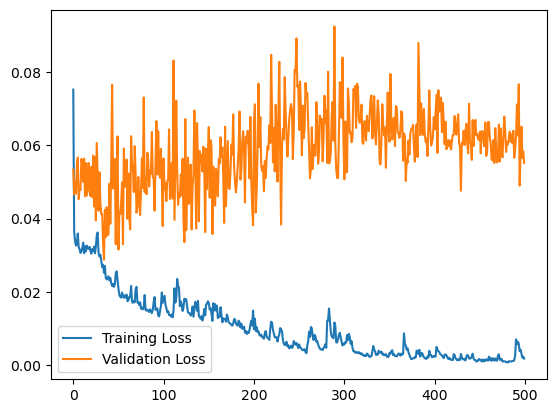

In [70]:
# Plotting the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [71]:
inputs = prepare_test_data(dataset, TestData)

In [72]:
X_test = reshape_test_data(inputs)

In [73]:
predicted_power_generation = regressor.predict(X_test)

1/1 [==============================] - 5s 5s/step


In [74]:
# Inverse transforming predicted values
predicted_power_generation = sc.inverse_transform(predicted_power_generation)

In [75]:
def create_result_dataframe(test_data, predicted_data):
    True_Power_Generation = test_data["Power_Generation"].to_list()
    Predicted_Power_Generation = [x[0] for x in predicted_data]
    dates = test_data.index.to_list()
    Machine_Df = pd.DataFrame(data={
        "Date": dates,
        "TruePowerGeneration": True_Power_Generation,
        "PredictedPowerGeneration": Predicted_Power_Generation
    })
    return Machine_Df

In [76]:
# Creating a DataFrame for visualization
Machine_Df = create_result_dataframe(TestData, predicted_power_generation)

In [77]:
def plot_results(dataframe):
    x = dataframe["Date"]
    y_true = dataframe["TruePowerGeneration"]
    y_pred = dataframe["PredictedPowerGeneration"]

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_true, label='True Power Generation', color='green')
    plt.plot(x, y_pred, label='Predicted Power Generation', color='red')
    plt.xlabel('Date')
    plt.ylabel('Power Generation')
    plt.title('True vs Predicted Power Generation')
    plt.legend()
    plt.show()

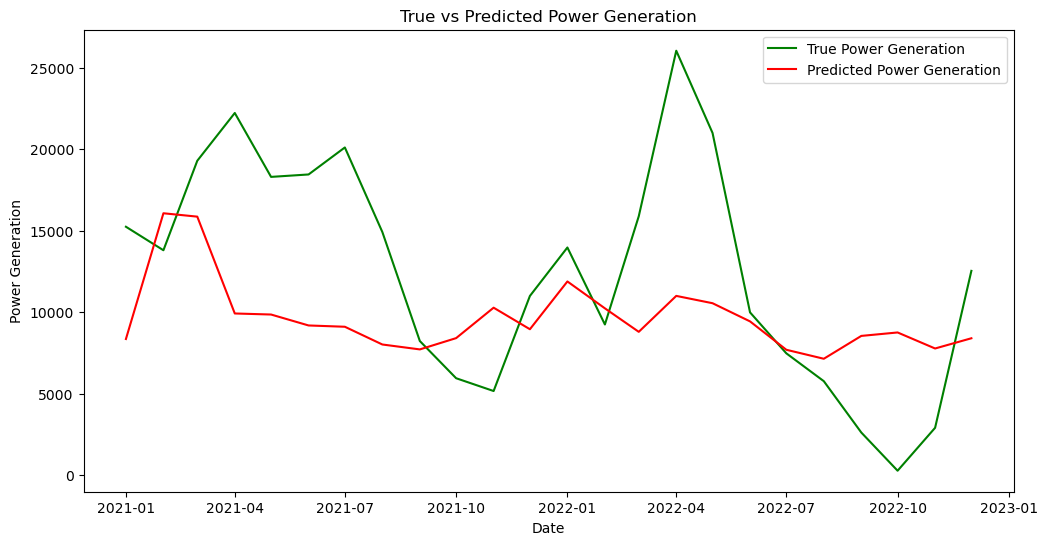

In [78]:
plot_results(Machine_Df)

In [27]:
Machine_Df

,Date,TruePowerGeneration,PredictedPowerGeneration
0,2013-01-01,7136.0,6368.949219
1,2013-02-01,13222.0,11750.820312
2,2013-03-01,15994.5,21810.099609
3,2013-04-01,17874.5,24376.322266
4,2013-05-01,13225.0,16159.473633
...,...,...,...
115,2022-08-01,5769.0,7289.997070
116,2022-09-01,2617.0,8954.738281
117,2022-10-01,273.0,7561.600586
118,2022-11-01,2907.5,6387.950684


In [28]:
Machine_Df.to_excel('LSTM Output.xlsx', index=True)